In [136]:
#import keras
import nltk
import pandas as pd
import numpy as np
import re
import codecs
import gc
from nltk.corpus import wordnet
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from pivottablejs import pivot_ui
import random 
gc.collect()
    

7351

In [137]:
inputFile="../data/cleaned/outputFile2-0-500000.csv" 
df = pd.read_csv(inputFile, dtype = {"primary_price" : "string"})
df = df.drop(['id'], axis=1)
df=df[0:1000]

# our categories and their related words
classes=['unisex', 'men', 'women', 'kid', 'baby']
manNet=['man','men', 'male', 'gentleman', 'gent','masculine',' manlike', ' mannish']
womanNet=['woman', 'women', 'lady', 'female' 'ladies', 'girl','feminine','unmacho','metrosexual' ]
babyNet= ['baby','toddler','infant', 'babe', 'bambino', 'infant', 'neonate', 'newborn']
kidNet=['kid','child', 'children', 'child', 'youth', 'joni','schoolchild', 'schoolgirl', 'schoolkid','junior']
unisexNet=['unisex','androgynous', 'genderless', 'unisexual']




In [138]:
# Helper Functions

def plot_class_distribution (data_frame, groupby_feature,class_name, starting_index=0):
    grouped  = data_frame.groupby([class_name]) 
    values=grouped[groupby_feature].agg(np.size)[starting_index:]  
    labels =  values.index.tolist()  
    y_pos = np.arange(len(labels))
    plt.bar(y_pos, values)
    plt.xticks(y_pos, labels)
    plt.xlabel('Product categories')
    plt.ylabel('Number of Products')
    plt.show()



In [139]:
#Cleaning the dataset


#map NLTK’s POS tags
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)


#Lemmatize Normalization
def normalize (tokens):
    lem = WordNetLemmatizer()
    return [lem.lemmatize(token,pos=get_wordnet_pos(token)) for token in tokens]

#clean up  tokenized  data
def standardize_tokens (tokens):
    return [token.lower() for token in tokens]

#Few regular expressions to clean up  text data
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r".com", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.replace(r"nan", "")
    df[text_field] = df[text_field].str.lower()
    #tokenize text
    df[text_field] = df[text_field].apply(word_tokenize)
    #remove stop words
    stop_words=set(stopwords.words("english"))
    df[text_field] = df[text_field].apply(lambda x: [item for item in x if item not in stop_words] )
    #normalize text
    df[text_field] = df[text_field].apply(normalize)
        
   


In [140]:
df.head()

,product_type,vendor_name,title,store_domain,store_product_brand_domain,description,primary_price,full_store_product_url
0,Cookware,Hestan,Hestan Nanobond Stainless 3qt/2.8L covered sau...,atlantagrillcompany.com,hestanculinary.com,NaN,290.0,https://atlantagrillcompany.com/products/hesta...
1,Cookware,Hestan,Hestan Nanobond Titanium Stockpot 8-Quart,atlantagrillcompany.com,hestanculinary.com,NaN,450.0,https://atlantagrillcompany.com/products/hesta...
2,Skillets,Hestan,"Hestan Nanobond 8.5"" Open Skillet",dasallas.com,hestanculinary.com,NaN,189.95,https://dasallas.com/products/hestan-nanobond-...
3,Saucepans & Sauciers,Hestan,Hestan Nanobond 5-Quart Covered Essential Pan ...,dasallas.com,hestanculinary.com,NaN,499.95,https://dasallas.com/products/hestan-nanobond-...
4,Cookware,Hestan,Hestan ProBond Forged Stainless Steel Ultimate...,atlantagrillcompany.com,hestanculinary.com,NaN,799.99,https://atlantagrillcompany.com/products/hesta...


In [141]:

df['title']=df['title'].astype(str)
df['product_type']=df['product_type'].astype(str)
df['description']=df['description'].astype(str)
df['store_domain']=df['store_domain'].astype(str)
df['vendor_name']=df['vendor_name'].astype(str)
df['store_product_brand_domain']=df['store_product_brand_domain'].astype(str)
 
# df['all_text_original'] = df.values.sum(axis=1)
#df['all_text_original'] = df.apply( str.join( " " ))

df['all_text_original'] = df['product_type']+" "+df['vendor_name']+" "+df['title']+" "+df['store_domain']+" "+df['store_product_brand_domain']+" "+df['description']
df['vendor_name_original'] = df['vendor_name'].str.lower()

standardize_text(df, 'product_type')
standardize_text(df, 'vendor_name')
standardize_text(df, 'title')
standardize_text(df, 'store_domain')
standardize_text(df, 'description')
standardize_text(df,'store_product_brand_domain')

#combine all token in all columns into one column
#df['all_tokens'] = df.values[:,['product_type','vendor_name', 'title', 'store_domain', 'description']].sum(axis=1)
df['all_tokens'] = df.values[:,0:6].sum(axis=1)

 
    

##  Frequency of the categories and their synonyms in the product information 


In [142]:
#count occurence of keyword in the list
def countFreq (product_info, keywordList):
    total_count =0
    for item in product_info:
      total_count += keywordList.count(item)
    return total_count


        

df['unisex'] = df['all_tokens'].apply(countFreq,keywordList=unisexNet)   
df['men'] = df['all_tokens'].apply(countFreq,keywordList=manNet) 
df['women'] = df['all_tokens'].apply(countFreq,keywordList=womanNet)  
df['baby'] = df['all_tokens'].apply(countFreq,keywordList=babyNet)  
df['kid'] = df['all_tokens'].apply(countFreq,keywordList=kidNet)
  
df['class']=  '-1'

display(df.head())

,product_type,vendor_name,title,store_domain,store_product_brand_domain,description,primary_price,full_store_product_url,all_text_original,vendor_name_original,all_tokens,unisex,men,women,baby,kid,class
0,[cookware],[hestan],"[hestan, nanobond, stainless, 3qt, 2, 8l, cove...",[atlantagrilpany],[hestanculinary],[],290.0,https://atlantagrillcompany.com/products/hesta...,Cookware Hestan Hestan Nanobond Stainless 3qt/...,hestan,"[cookware, hestan, hestan, nanobond, stainless...",0,0,0,0,0,-1
1,[cookware],[hestan],"[hestan, nanobond, titanium, stockpot, 8, quart]",[atlantagrilpany],[hestanculinary],[],450.0,https://atlantagrillcompany.com/products/hesta...,Cookware Hestan Hestan Nanobond Titanium Stock...,hestan,"[cookware, hestan, hestan, nanobond, titanium,...",0,0,0,0,0,-1
2,[skillet],[hestan],"[hestan, nanobond, 8, 5, '', open, skillet]",[dasallas],[hestanculinary],[],189.95,https://dasallas.com/products/hestan-nanobond-...,"Skillets Hestan Hestan Nanobond 8.5"" Open Skil...",hestan,"[skillet, hestan, hestan, nanobond, 8, 5, '', ...",0,0,0,0,0,-1
3,"[saucepan, sauciers]",[hestan],"[hestan, nanobond, 5, quart, cover, essential,...",[dasallas],[hestanculinary],[],499.95,https://dasallas.com/products/hestan-nanobond-...,Saucepans & Sauciers Hestan Hestan Nanobond 5-...,hestan,"[saucepan, sauciers, hestan, hestan, nanobond,...",0,0,0,0,0,-1
4,[cookware],[hestan],"[hestan, probond, forge, stainless, steel, ult...",[atlantagrilpany],[hestanculinary],[],799.99,https://atlantagrillcompany.com/products/hesta...,Cookware Hestan Hestan ProBond Forged Stainles...,hestan,"[cookware, hestan, hestan, probond, forge, sta...",0,0,0,0,0,-1


## Choose the label with the highest occurance of the keyword 

In [143]:
# choose the label with the highest occurance of the keyword 
def findLabel(row): 
        maxCount=max(row)
        if maxCount> 0:
            maxLabel= row[row == maxCount].index[0] 
        else:
            maxLabel='-1'
        return maxLabel
    
df.loc[:,'class']=df.loc[:,classes].apply(findLabel,axis=1) 
display (df.head())

,product_type,vendor_name,title,store_domain,store_product_brand_domain,description,primary_price,full_store_product_url,all_text_original,vendor_name_original,all_tokens,unisex,men,women,baby,kid,class
0,[cookware],[hestan],"[hestan, nanobond, stainless, 3qt, 2, 8l, cove...",[atlantagrilpany],[hestanculinary],[],290.0,https://atlantagrillcompany.com/products/hesta...,Cookware Hestan Hestan Nanobond Stainless 3qt/...,hestan,"[cookware, hestan, hestan, nanobond, stainless...",0,0,0,0,0,-1
1,[cookware],[hestan],"[hestan, nanobond, titanium, stockpot, 8, quart]",[atlantagrilpany],[hestanculinary],[],450.0,https://atlantagrillcompany.com/products/hesta...,Cookware Hestan Hestan Nanobond Titanium Stock...,hestan,"[cookware, hestan, hestan, nanobond, titanium,...",0,0,0,0,0,-1
2,[skillet],[hestan],"[hestan, nanobond, 8, 5, '', open, skillet]",[dasallas],[hestanculinary],[],189.95,https://dasallas.com/products/hestan-nanobond-...,"Skillets Hestan Hestan Nanobond 8.5"" Open Skil...",hestan,"[skillet, hestan, hestan, nanobond, 8, 5, '', ...",0,0,0,0,0,-1
3,"[saucepan, sauciers]",[hestan],"[hestan, nanobond, 5, quart, cover, essential,...",[dasallas],[hestanculinary],[],499.95,https://dasallas.com/products/hestan-nanobond-...,Saucepans & Sauciers Hestan Hestan Nanobond 5-...,hestan,"[saucepan, sauciers, hestan, hestan, nanobond,...",0,0,0,0,0,-1
4,[cookware],[hestan],"[hestan, probond, forge, stainless, steel, ult...",[atlantagrilpany],[hestanculinary],[],799.99,https://atlantagrillcompany.com/products/hesta...,Cookware Hestan Hestan ProBond Forged Stainles...,hestan,"[cookware, hestan, hestan, probond, forge, sta...",0,0,0,0,0,-1


##  Choose some random record to check the labeling

In [145]:
labeled_data=df[df['class']!= '-1'].copy()
unlabeled_data_index=df.index.difference(labeled_data.index)

random_records=random.sample(labeled_data.index.to_list(), k=30) 
test=labeled_data.loc[random_records, ['class','product_type','full_store_product_url' ,'all_text_original']]
test.to_csv("../data/validate/test_random_labeled_data_Round1.csv", index=True)

In [146]:
test

,class,product_type,full_store_product_url,all_text_original
52,kid,[],https://supplementfirst.com/products/trace-min...,nan Trace Minerals Research Trace Minerals Res...
204,kid,[],https://supplementfirst.com/products/trace-min...,nan Trace Minerals Research Trace Minerals Res...
176,kid,"[vitamin, mineral]",https://xsnonline.com/products/liquid-kids-multi,Vitamins & Minerals Trace Minerals Liquid Kid'...
128,kid,[supplement],NaN,Supplements Trace Minerals Research Trace Mine...
30,kid,[],https://supplementfirst.com/products/trace-min...,nan Trace Minerals Research Trace Minerals Res...
333,baby,[seafood],https://basquefoodhunter.com/products/serrats-...,Seafood Serrats Baby Sardines in Olive Oil tin...
910,kid,[cascos],https://dfcc.mx/products/casco-sport-kids,Cascos Orbea Casco Sport kids dfcc.mx orbea.co...
277,baby,[seafood],https://basquefoodhunter.com/products/serrats-...,Seafood Serrats Baby Sardines in Olive Oil tin...
215,kid,"[personal, care]",https://xsnonline.com/products/childrens-chewa...,Personal Care Trace Minerals Children's Chewab...
668,baby,"[swim, diaper]",https://cutelittleme.ca/products/omaiki-baby-h...,Swim Diapers Omaiki Omaiki -Baby H2Ö One-Size ...


In [147]:

print("Number of records labeled in round 1:",labeled_data.shape[0])
print("Number of records not labeled in round 1:",unlabeled_data.shape[0])

Number of records labeled in round 1: 30
Number of records not labeled in round 1: 970


## The distribution of classes including Nan

In [148]:
grouped  = df.groupby(['class'])     
print(grouped['product_type'].agg(np.size))

class
-1        970
baby        9
kid        19
unisex      1
women       1
Name: product_type, dtype: int64


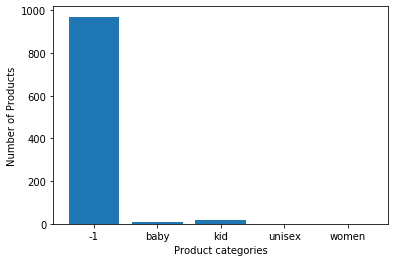

In [149]:
plot_class_distribution (df, 'product_type','class', starting_index=0)

## The distribution of classes excluding Nan

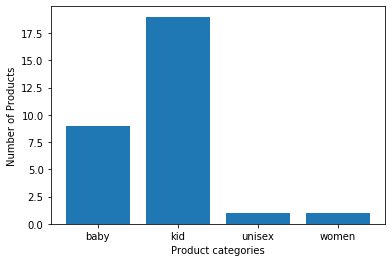

In [150]:
plot_class_distribution (df, 'product_type','class', starting_index=1)

## Find the most common keywords in product information and label records containg those keywords


###  1) Define commmon keywords for each category

In [151]:
unisexProduct= ['electronics', 'phone','fruit','movie','vegetable', 
                'seafood','ipad','video','music','book', 'dairy',
                'egg', 'fridge', 'phone', 'supplement', 'cable', 
                'cookware', 'cook', 'novel', 'bike','headphone',
               'appliance','battery', 'vitamin','fence', 'garden',
                'speaker','camera', 'kitchen', 'radio', 'backpack'
                'frozen', 'food', 'household', 'safety', 'skate' ]

womanProduct=['jewellery', 'pregnancy', 'make up', 'nail polish', 
              'eye shadow', 'skirt','Manicure', 'Pedicure'   ]

menProduct= ['shave', 'tuxedo', 'tie'] 


kidProduct=['school', 'disney', 'spider', 'barbie','doll'  ]

babyProduct=['Pacifier' ,'Strollers', 'diapers', 'potty', 'walkers',
             'playmat',  'Car Seat', 'lip liner', 'Babyliss', 'maternity', 
             'Teether', 'nursery', 'carrier', 'crib', 'Rattle', 'sleeper']




#lemmitize and standardize the all the categories lists
unisexProduct=normalize(unisexProduct)
unisexProduct=standardize_tokens(unisexProduct)
menProduct=normalize(menProduct)
menProduct=standardize_tokens(menProduct)
womanProduct=normalize(womanProduct)
womanProduct=standardize_tokens(womanProduct)
kidProduct=normalize(kidProduct)
kidProduct=standardize_tokens(kidProduct) 
babyProduct=normalize(babyProduct)
babyProduct=standardize_tokens(babyProduct) 

all_categories_lists=[unisexProduct,   menProduct ,  womanProduct ,  kidProduct ,  babyProduct]


### 2) Find most commmon words in product information which are not included in the categories lists

####   Let's inspect word and vocabulary of our data set

In [154]:
#combine all rows' tokens  into one list
all_words=list([a for b in df['all_tokens'].tolist() for a in b])
all_words=list(filter(lambda a: a not in [',', '(', ')', "'", '"'], all_words))


VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))

11594 words total, with a vocabulary size of 1211


In [155]:
#Find the most frequent words which are not included  categories lists
from nltk.probability import FreqDist
fdist = FreqDist(all_words)
all_keyword_lists=all_categories_lists + manNet+womanNet+babyNet+kidNet+unisexNet
for word,number in fdist.most_common(30):
    if word not in all_keyword_lists:
        print (word, end = ', ')

    

orbea, mineral, trace, traceminerals, serrats, bike, research, booja, actiu, omaiki, de, co, vinyl, '', damsel, au, basquefoodhunter, nz, damselindior, earring, supplement, liquid, white, jewellery, mirrormirrorboutique, rail, xsnonline, tuna, innerspacewa, fence, 

#### None of these keywords can help us to label more products. so, let's move to  label the records based on our selected common keywords

### 3) Label records containg common keywords

In [161]:
#find the total frequency of a list of keywords in a tokenized list 
def count_occurance_keyword ( tokenized_list, category_list ) :
        count=0
        text_data= ' '.join( tokenized_list)+" "
        for keyword in category_list:
                count = text_data.count(keyword+" ") 
        return count     
    
def findLabel_commonKeywords(dataFrame, feature): 
    count_unisex = count_occurance_keyword(dataFrame[feature], unisexProduct) 
    count_men   =  count_occurance_keyword(dataFrame[feature], menProduct) 
    count_woman  = count_occurance_keyword(dataFrame[feature], womanProduct) 
    count_kid    = count_occurance_keyword(dataFrame[feature], kidProduct) 
    count_baby   = count_occurance_keyword(dataFrame[feature], babyProduct) 
    
    index=['unisex', 'men', 'women', 'kid', 'baby']
    counters=[count_unisex, count_men, count_woman,count_kid,count_baby]
    frequency= pd.Series(counters, index=index)
    
    # find label with maximum frequency
    max_frequency= max(frequency)
    max_label= frequency.idxmax() if max_frequency> 0 else '-1' 
    return max_label


#notLabled = df[ df['class'] == '-1' ]  
not_labled_index=  df['class'] == '-1' 
df.loc[not_labled_index, 'class'] = df.loc[not_labled_index,:].apply(findLabel_commonKeywords, axis=1,args=['all_tokens']) 


In [162]:
#Ignore thi line, just to test funstion
#count_occurance_keyword(['tie','men', 'baby', 'shaver','shaves', 'tie','shave', 'tiered'], ['tie', 'shave']) 

#  It seems nothing is labeled in this round?

In [167]:
df.loc[not_labled_index, 'class']

0      -1
1      -1
2      -1
3      -1
4      -1
       ..
995    -1
996    -1
997    -1
998    -1
999    -1
Name: class, Length: 970, dtype: object

In [163]:
#display(  df[ df['class'] != '-1' ].head() )


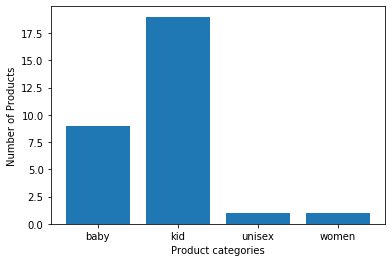

In [164]:
plot_class_distribution (df, 'product_type','class', starting_index=1)

In [165]:

print(df['class'].value_counts())

-1        970
kid        19
baby        9
women       1
unisex      1
Name: class, dtype: int64


# Export Labeled Data

In [117]:
df['all_text']= df['all_tokens'].apply(lambda x: " ".join(x))
df.to_csv("../data/labeled/labeled_dataV1.csv", index=True)
 


##  Choose some random records that are labeled in this round in order to check the labeling performance

In [125]:
df.index.difference(labeled_data.index)
# choose records which are not labeled in the first round, but in the second round
labeled_data=df[df['class']!= '-1' ].copy()
labeled_data=df[df['class']!= '-1' and df.index in unlabeled_data_index  ].copy()
unlabeled_data_index=df.index.difference(labeled_data.index)

970

In [84]:
labeled_data=unlabeled_data[unlabeled_data['class']!= '-1'].copy()
unlabeled_data_index=df.index.difference(labeled_data.index)
random_records=random.sample(labeled_data.index.to_list(), k=10) 
test=labeled_data.loc[random_records, ['class','product_type','full_store_product_url' ,'all_text_original']]
test.to_csv("../data/validate/test_random_labeled_data_Round2.csv", index=True)

ValueError: Sample larger than population or is negative

In [ ]:

print("Number of records labeled in round 2:",labeled_data.shape[0])
print("Number of records not labeled yet:",unlabeled_data.shape[0])

In [89]:
 unlabeled_data['class']!= '-1'

0         False
1         False
2         False
3         False
4         False
          ...  
499995    False
499996    False
499997    False
499998    False
499999    False
Name: class, Length: 438708, dtype: bool

## Labeling more records based on vendor names

If products from a vendor all belong to one particular category (given that at least 10 products are listed), we can assign that category to other products from the same vendor

In [ ]:
#pivot_ui(labeled_data )

In [ ]:
homo_brands= {}

grouped  = labeled_data.groupby(['vendor_name_original'])
for key, group in grouped:
   class_group = grouped.get_group(key).groupby(['class']) 
   #print(key, len(class_group ), class_group['class'].count() )
   # if all products belong to one category
   if len(class_group)==1:
      # If at least 10 products are listed for a company
      if  (class_group['class'].count()[0]) > 10 :
         homo_brands[key]= list(class_group.groups.keys())[0]

print(homo_brands)

In [ ]:
homo_vendor_bool=  df['vendor_name_original'].apply( lambda x: x in list(homo_brands.keys())) 
not_labled_bool=   df['class'] == '-1'
#records which are not labeled yet and belong to homo vendor
homo_notLabeld_bool=np.logical_and(not_labled_bool, homo_vendor_bool)
homo_notLabeld_index= df[homo_notLabeld_bool].index

pd.DataFrame({'homo_vendor': homo_vendor_bool, 'not_labled_bool': not_labled_bool,'homo_notLabeld_bool':homo_notLabeld_bool  })
display(df) 

In [ ]:
print("not labeled \n",df[not_labled_bool].index)
print("homo \n",df[homo_vendor_bool].index)
print("homo and notlabeled \n",df[homo_notLabeld_bool].index)


In [ ]:
print(df['class'].value_counts())

def get_homo_class ( x ):
    vendor=x['vendor_name_original']
    #print(vendor, homo_brands[vendor])
    return homo_brands[vendor]
    
df.loc[homo_notLabeld_index, 'class'] = df.loc[homo_notLabeld_index,:].apply(get_homo_class, axis=1)
print(df['class'].value_counts())
display(df)

# Export Labeled Data

In [ ]:
df['all_text']= df['all_tokens'].apply(lambda x: " ".join(x))
df.to_csv("../data/labeled/labeled_dataV2.csv", index=True)
 


In [ ]:
display(labeled_data.head())

##  Choose some random records that are labeled in thi round in order to check the labeling performance

In [ ]:
labeled_data=unlabeled_data[unlabeled_data['class']!= '-1'].copy()
unlabeled_data=df[df['class']== '-1'].copy()
random_records=random.sample(labeled_data.index.to_list(), k=40) 
test=labeled_data.loc[random_records, ['class','product_type','full_store_product_url' ,'all_text_original']]
test.to_csv("../data/validate/test_random_labeled_data_Round3.csv", index=True)

In [ ]:
#Note
#https://touchdolls.com/ is for ladies not kids
#tying lemm -> tie